# AUTOENCODER aug data TESTE DE VALIDAÇÃO CRUZADA

In [1]:
# Cell for pip installing required packages
# %pip install plaidml-keras
# %pip install h5py==2.10
# %pip install 'h5py==2.10.0' --force-reinstall

# Uninstall current versions
# %pip uninstall tensorflow -y
# %pip uninstall keras -y

# Install specific versions
# %pip install tensorflow
# %pip install keras==2.1.6

# %pip install mediapipe

# Install pandas, joblib, and matplotlib
# %pip install pandas joblib matplotlib
# %pip install scikit-learn

In [2]:
import os

# Ensure that TensorFlow can see the GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 

import tensorflow as tf

# Check if TensorFlow can access the GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

import numpy as np 
import pandas as pd
import joblib
import matplotlib.pyplot as plt

# Inicialize listas para armazenar perdas de treinamento e perdas de validação em cada fold
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import KFold
from tensorflow.keras import layers

print(tf.__version__)

Num GPUs Available:  0
2.13.0


In [3]:
# Cell 2: Funções para carregar e preparar dados
def load_and_prepare_data(directory, window_size):
    all_frames = []
    valid_csv_count = 0  # Contador para arquivos CSV válidos

    for filename in os.listdir(directory):
        if filename.startswith('angles'):  # Alterado para 'low_pass_angles'
            df = pd.read_csv(f'{directory}/{filename}')
            
            # Verificar se o DataFrame não está vazio
            if not df.empty:
                valid_csv_count += 1
                # Tratamento de outliers e média móvel
                df = df.clip(lower=df.quantile(0.01), upper=df.quantile(0.99), axis=1)
                df = df.rolling(window=window_size, min_periods=1).mean()
                all_frames.append(df)

    if valid_csv_count == 0:
        print("Nenhum arquivo CSV válido encontrado.")
    else:
        print(f"Arquivos CSV válidos encontrados: {valid_csv_count}")
    
    return pd.concat(all_frames)

# Cell 2: Modified function to create time series data
def create_time_series_data(data, n_steps):
    X = []
    for i in range(len(data) - n_steps):
        seq_x = data[i:i+n_steps]
        X.append(seq_x)
    return np.array(X)

# Usando a função modificada
n_predict = 10  # Número de frames a serem previstos

#0.3
def augment_data(data, noise_level=0.05, time_shift=3, use_noise=True, use_shift=True, reduction_factor=1.0):
    augmented_data = [data]

    if use_noise:
        # Adding noise
        noise = np.random.normal(0, noise_level, data.shape)
        data_noisy = data + noise
        augmented_data.append(data_noisy)

    if use_shift:
        # Time shifting
        data_shifted = np.roll(data, time_shift, axis=0)
        augmented_data.append(data_shifted)

    # Concatenate original and augmented data
    augmented_data = np.vstack(augmented_data)

    # Select a random subset of the augmented data
    np.random.shuffle(augmented_data)
    reduced_size = int(len(augmented_data) * reduction_factor)
    augmented_data = augmented_data[:reduced_size]

    return augmented_data

In [4]:
# Cell 3: Construção do Autoencoder LSTM
import os

from keras.layers import RepeatVector, TimeDistributed
from keras.regularizers import l2
from keras.layers import Dropout

# Carregar dados
directory = 'InfinityRepVideos/armraise/csv'
window_size = 3
data = load_and_prepare_data(directory, window_size)

# Aplicar aumento de dados
data_augmented = augment_data(data, use_noise=True, use_shift=False)

# Escalar dados
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_augmented)

# Salvar o scaler para uso posterior
joblib.dump(scaler, 'InfinityRepVideos/armraise/model/autoencoder_lstm_scaler.save')

# Preparar dados para LSTM
n_steps = 48  # Número de frames por sequência
n_features = scaled_data.shape[1]  # Número de características
X = create_time_series_data(scaled_data, n_steps)

# Hiperparâmetros
learning_rate = 0.001
n_units = 300
another_n_units = 150
batch_size = 32

# Construir o modelo Autoencoder LSTM
model = Sequential()

# Encoder
model.add(LSTM(units=n_units, activation='relu', kernel_regularizer=l2(0.01), input_shape=(n_steps, n_features), return_sequences=False))
model.add(Dropout(0.2)) 
model.add(RepeatVector(n_steps))

# Add more encoder layers
model.add(LSTM(units=another_n_units, activation='relu', kernel_regularizer=l2(0.01), return_sequences=False))
model.add(Dropout(0.2))
model.add(RepeatVector(n_steps))

# Decoder
model.add(LSTM(units=n_units, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))

# Add more decoder layers
model.add(LSTM(units=another_n_units, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))

# Compilar o modelo
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)
model_checkpoint = ModelCheckpoint('InfinityRepVideos/armraise/model/221223_100_50epochs_16batch_dropout02_autoencoder_lstm_best_model.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)

Arquivos CSV válidos encontrados: 100


In [5]:
# Cell 4: Treinamento do Modelo com Validação Cruzada K-Fold
# Inicializar listas para armazenar perdas de treinamento e perdas de validação em cada fold
train_losses = []
val_losses = []

kf = KFold(n_splits=5)

fold = 1
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]

    print(f"Treinando Fold {fold}...")
    history = model.fit(X_train, X_train, epochs=300, batch_size=batch_size, validation_data=(X_val, X_val), callbacks=[early_stopping, model_checkpoint], verbose=1)

    val_loss = model.evaluate(X_val, X_val)
    print(f'Perda de Validação para o Fold {fold}: {val_loss}')

    fold += 1

Treinando Fold 1...
Epoch 1/10
1063/8901 [==>...........................] - ETA: 6:49 - loss: 0.1228

KeyboardInterrupt: 

1113/1113 [==============================] - 27s 23ms/step
Erro de Reconstrução Médio: 0.01976714910126847
Erro de Reconstrução Máximo: 0.03137768151283172


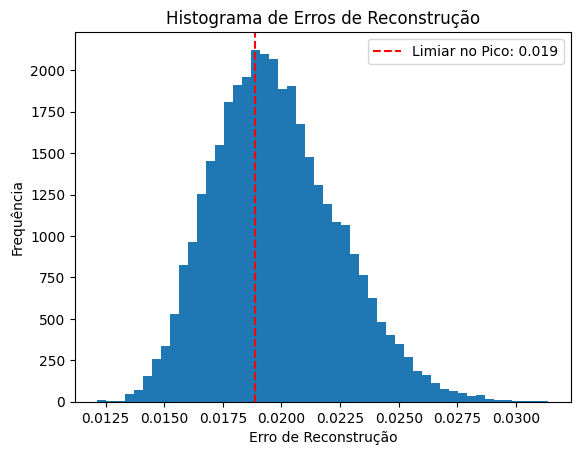

Limiar de Detecção de Anomalias: 0.01888204895653068


In [ ]:
# Cell 5: Plotagem de Gráficos

# Após o treinamento, você pode calcular os erros de reconstrução e plotar um histograma
reconstructions = model.predict(X_val)
reconstruction_errors = np.mean(np.square(X_val - reconstructions), axis=(1, 2))  # Erros de reconstrução médios por amostra

# Lidar com valores NaN substituindo-os por zero
reconstruction_errors = np.nan_to_num(reconstruction_errors, nan=0.0)

print(f'Erro de Reconstrução Médio: {reconstruction_errors.mean()}')
print(f'Erro de Reconstrução Máximo: {reconstruction_errors.max()}')

# Plotar um histograma dos erros de reconstrução e encontrar o bin com a maior frequência
counts, bin_edges = np.histogram(reconstruction_errors, bins=50)
max_count_idx = np.argmax(counts)
peak_bin = (bin_edges[max_count_idx] + bin_edges[max_count_idx + 1]) / 2

# Plotar o histograma
plt.hist(reconstruction_errors, bins=50)
plt.title('Histograma de Erros de Reconstrução')
plt.xlabel('Erro de Reconstrução')
plt.ylabel('Frequência')

# Desenhar uma linha no pico do histograma
plt.axvline(x=peak_bin, color='r', linestyle='--', label=f'Limiar no Pico: {peak_bin:.3f}')
plt.legend()

plt.show()

# Atualizar o limiar de detecção de anomalias para o valor do pico
anomaly_threshold = peak_bin
print(f'Limiar de Detecção de Anomalias: {anomaly_threshold}')